In [4]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [5]:
with open('C:/Users/kzadk/OneDrive/Desktop/YT_api_key.txt') as f:
    key = f.read()

api_key = key
api_service_name = 'youtube'
api_version = 'v3' 

youtube = build(api_service_name, api_version, developerKey=api_key)

channel_ids = ['UCCezIgC97PvUuR4_gbFUs5g', # Corey Shafer
               'UCcIXc5mJsHVYTZR1maL5l9w', # DeepLearningAI
               'UCr8O8l5cCX85Oem1d18EezQ', # DanielBourke
               'UCfzlCWGWYyIQ0aLC5w48gBQ', # Sentdex
               'UCtYLUTtgS3k1Fg4y5tAhLbw', # StatQuest
               'UCYO_jab_esuFRV4b17AJtAw' # 3Blue1Brown
               ]


### Function to get desired channels statistics


In [6]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
        part = 'snippet, contentDetails, statistics',
        id = ','.join(channel_ids))
    response = request.execute()
    
    for i in range(len(response['items'])):
        data = dict(Channel_name = response['items'][i]['snippet']['title'],
                    Subscribers = response['items'][i]['statistics']['subscriberCount'],
                    Views = response['items'][i]['statistics']['viewCount'],
                    playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)

    return all_data

In [7]:
data = get_channel_stats(youtube, channel_ids)

In [8]:
len(data)

6

In [9]:
yt_data = pd.DataFrame(data)

In [10]:
yt_data

,Channel_name,Subscribers,Views,playlist_id
0,Daniel Bourke,154000,7373230,UUr8O8l5cCX85Oem1d18EezQ
1,StatQuest with Josh Starmer,940000,49797548,UUtYLUTtgS3k1Fg4y5tAhLbw
2,DeepLearningAI,225000,14356491,UUcIXc5mJsHVYTZR1maL5l9w
3,sentdex,1230000,109961541,UUfzlCWGWYyIQ0aLC5w48gBQ
4,3Blue1Brown,5230000,341581155,UUYO_jab_esuFRV4b17AJtAw
5,Corey Schafer,1140000,86156126,UUCezIgC97PvUuR4_gbFUs5g


In [11]:
yt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Channel_name  6 non-null      object
 1   Subscribers   6 non-null      object
 2   Views         6 non-null      object
 3   playlist_id   6 non-null      object
dtypes: object(4)
memory usage: 320.0+ bytes


In [12]:
yt_data['Subscribers'] = pd.to_numeric(yt_data['Subscribers'])
yt_data['Views'] = pd.to_numeric(yt_data['Views'])

In [13]:
yt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Channel_name  6 non-null      object
 1   Subscribers   6 non-null      int64 
 2   Views         6 non-null      int64 
 3   playlist_id   6 non-null      object
dtypes: int64(2), object(2)
memory usage: 320.0+ bytes


### Showing plots for numerical data of channels


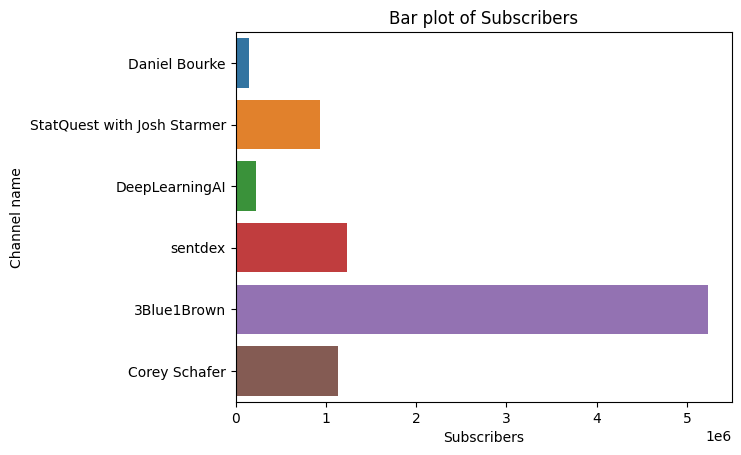

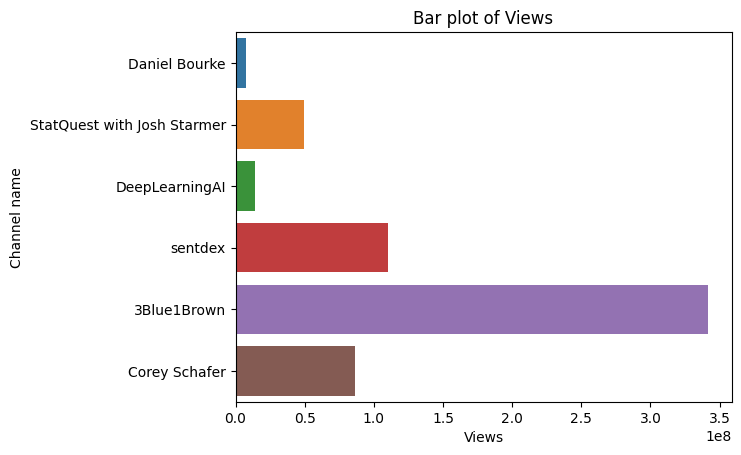

In [14]:
for column in yt_data.columns:
    if yt_data[column].dtype.kind in 'iufc':
        sns.barplot(x=yt_data[column], y=yt_data['Channel_name'])
        plt.xlabel(column)
        plt.ylabel('Channel name')
        plt.title(f'Bar plot of {column}')
        plt.show()

### Function to get ids of videos


In [15]:
playlist_id = yt_data.loc[yt_data['Channel_name'] == '3Blue1Brown', 'playlist_id'].iloc[0]

In [16]:
playlist_id

'UUYO_jab_esuFRV4b17AJtAw'

In [17]:
def get_channel_videos_ids(youtube, playlist_id):

    request = youtube.playlistItems().list(
        part = 'contentDetails',
        playlistId = playlist_id,
        maxResults = 50)
    response = request.execute()

    videos_ids = []

    for i in range(len(response['items'])):
        videos_ids.append(response['items'][i]['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    more_pages = True

    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                part = 'contentDetails',
                playlistId = playlist_id,
                maxResults = 50,
                pageToken = next_page_token)
            response = request.execute()

            for i in range(len(response['items'])):
                videos_ids.append(response['items'][i]['contentDetails']['videoId'])

            next_page_token = response.get('nextPageToken')
    return videos_ids

In [18]:
videos_ids = get_channel_videos_ids(youtube, playlist_id)

In [21]:
def get_videos_details(youtube, videos_ids):

    all_video_stats = []

    for i in range(0, len(videos_ids), 50):
        request = youtube.videos().list(
            part = 'snippet, statistics',
            id = ','.join(videos_ids[i : i + 50]))
        response = request.execute()

        for video in response['items']:
            video_stats = dict(Title = video['snippet']['title'],
                               Published_date = video['snippet']['publishedAt'],
                               Views = video['statistics']['viewCount'],
                               Likes = video['statistics']['likeCount'],
                               Comments = video['statistics']['commentCount'])
            all_video_stats.append(video_stats)

        return all_video_stats

In [23]:
videos_details = get_videos_details(youtube, videos_ids)

In [24]:
video_data = pd.DataFrame(videos_details)

In [25]:
video_data

,Title,Published_date,Views,Likes,Comments
0,Why π is in the normal distribution (beyond in...,2023-04-02T15:30:13Z,961859,36880,1389
1,But what is the Central Limit Theorem?,2023-03-14T18:36:36Z,2146434,46589,1831
2,But what is a convolution?,2022-11-18T16:00:39Z,1760638,75733,2305
3,Researchers thought this was a bug (Borwein in...,2022-11-04T15:54:19Z,1825557,58205,1765
4,"We ran a contest for math explainers, here are...",2022-10-01T19:23:52Z,693442,35955,1104
5,How to lie using visual proofs,2022-07-03T15:03:56Z,2225176,90381,3602
6,Summer of Math Exposition 2 Invitation,2022-06-09T05:18:39Z,258657,12308,530
7,Olympiad level counting,2022-05-23T15:55:10Z,1549716,57198,2537
8,"Oh, wait, actually the best Wordle opener is n...",2022-02-13T18:33:24Z,5452012,142497,6659
9,Solving Wordle using information theory,2022-02-06T13:28:52Z,9655636,209768,8622
